## Imports

In [15]:
from google.colab import files
import io
import pandas as pd
from matplotlib import pyplot

from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

import missingno as msno
import seaborn as sns 

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Pre-process the election dataset "county_statistics.csv"

In [4]:
uploaded_1 = files.upload()


Saving county_statistics.csv to county_statistics.csv


In [5]:
county = pd.read_csv(io.BytesIO(uploaded_1['county_statistics.csv']))
county = county.dropna()
county = county.sort_values(['state', 'county'], ignore_index=True)
county['county'] = county['county'].str.upper() 
county['state'] = county['state'].str.upper()
county = county.drop(['Unnamed: 0'], axis=1)
county

,county,state,percentage16_Donald_Trump,percentage16_Hillary_Clinton,total_votes16,votes16_Donald_Trump,votes16_Hillary_Clinton,percentage20_Donald_Trump,percentage20_Joe_Biden,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden,lat,long,cases,deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,AUTAUGA,AL,0.734,0.240,24661.0,18110.0,5908.0,0.715,0.270,27639.0,19764.0,7450.0,32.539527,-86.644082,2173.0,31.0,55036.0,26899.0,28137.0,2.7,75.4,18.9,0.3,0.9,0.0,41016.0,55317.0,2838.0,27824.0,2024.0,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112.0,74.1,20.2,5.6,0.1,5.2
1,BALDWIN,AL,0.774,0.196,94090.0,72780.0,18409.0,0.762,0.223,108945.0,83055.0,24344.0,30.727750,-87.722071,6966.0,71.0,203360.0,99527.0,103833.0,4.4,83.1,9.5,0.8,0.7,0.0,155376.0,52562.0,1348.0,29364.0,735.0,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527.0,80.7,12.9,6.3,0.1,5.5
2,BARBOUR,AL,0.523,0.467,10390.0,5431.0,4848.0,0.536,0.456,10457.0,5605.0,4772.0,31.868263,-85.387129,1061.0,9.0,26201.0,13976.0,12225.0,4.2,45.7,47.8,0.2,0.6,0.0,20269.0,33368.0,2551.0,17561.0,798.0,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878.0,74.1,19.1,6.5,0.3,12.4
3,BIBB,AL,0.770,0.214,8748.0,6733.0,1874.0,0.784,0.207,9573.0,7508.0,1982.0,32.996421,-87.125115,878.0,15.0,22580.0,12251.0,10329.0,2.4,74.6,22.0,0.4,0.0,0.0,17662.0,43404.0,3431.0,20911.0,1889.0,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171.0,76.0,17.4,6.3,0.3,8.2
4,BLOUNT,AL,0.899,0.085,25384.0,22808.0,2150.0,0.896,0.096,27459.0,24595.0,2627.0,33.982109,-86.567906,2095.0,25.0,57667.0,28490.0,29177.0,9.0,87.4,1.5,0.3,0.1,0.0,42513.0,47412.0,2630.0,22021.0,850.0,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380.0,83.9,11.9,4.0,0.1,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3041,SWEETWATER,WY,0.729,0.194,16661.0,12153.0,3233.0,0.737,0.230,16603.0,12229.0,3823.0,41.659439,-108.882788,585.0,2.0,44527.0,22981.0,21546.0,16.0,79.6,0.8,0.6,0.6,0.5,31025.0,71083.0,4336.0,31700.0,1368.0,12.0,15.7,27.7,16.1,20.0,20.8,15.4,77.5,14.4,2.6,2.8,1.3,1.5,20.5,22739.0,78.4,17.8,3.8,0.0,5.2
3042,TETON,WY,0.322,0.601,12176.0,3920.0,7313.0,0.296,0.671,14677.0,4341.0,9848.0,43.935225,-110.589080,814.0,1.0,22923.0,12169.0,10754.0,15.0,81.5,0.5,0.3,2.2,0.0,16692.0,80049.0,4586.0,49200.0,4567.0,6.8,2.8,39.4,25.4,17.0,11.7,6.5,68.3,6.7,3.8,11.7,3.8,5.7,14.3,14492.0,82.1,11.4,6.5,0.0,1.3
3043,UINTA,WY,0.764,0.149,8053.0,6154.0,1202.0,0.797,0.169,9402.0,7496.0,1591.0,41.287818,-110.547578,488.0,3.0,20758.0,10593.0,10165.0,9.1,87.7,0.1,0.9,0.1,0.0,14235.0,54672.0,7803.0,27115.0,2401.0,14.9,20.0,30.4,19.4,18.1,16.1,16.1,77.4,14.9,3.3,1.1,1.3,2.0,19.9,9528.0,71.5,21.5,6.6,0.4,6.4
3044,WASHAKIE,WY,0.784,0.143,3715.0,2911.0,532.0,0.809,0.162,4012.0,3245.0,651.0,43.904516,-107.680187,160.0,7.0,8253.0,4118.0,4135.0,14.2,82.2,0.3,0.4,0.1,0.0,6125.0,51362.0,2570.0,27345.0,1689.0,12.8,17.5,32.1,16.3,17.6,18.8,15.3,77.2,10.2,0.0,6.9,1.3,4.4,14.3,3833.0,69.8,22.0,8.1,0.2,6.1


# Pre-process land area per county dataset "LND01.csv"

In [6]:
uploaded_3 = files.upload()

Saving LND01.csv to LND01.csv


In [7]:
area = pd.read_csv(io.BytesIO(uploaded_3['LND01.csv']))
area = area[['Areaname', 'LND110210D']]
area[['county','state']] = area.Areaname.str.split(", ", expand=True) 
area= area.drop(['Areaname'], axis=1)
area = area.dropna()
area.rename(columns = {'LND110210D':'area'}, inplace = True) 
area = area.sort_values(['state', 'county'], ignore_index=True)
area['county'] = area['county'].str.upper()
area['state'] = area['state'].str.upper()
area = area[['county', 'state', 'area']]

area

,county,state,area
0,ALEUTIANS EAST,AK,6981.94
1,ALEUTIANS WEST,AK,4390.28
2,ANCHORAGE,AK,1704.68
3,BETHEL,AK,40570.00
4,BRISTOL BAY,AK,503.84
...,...,...,...
3140,SWEETWATER,WY,10426.65
3141,TETON,WY,3995.38
3142,UINTA,WY,2081.26
3143,WASHAKIE,WY,2238.55


# Pre-process the population dataset. Used to ensure that our population data was correct in our inital dataset.

In [8]:
uploaded_2 = files.upload()

Saving co-est2019-annres.csv to co-est2019-annres.csv


In [9]:
pop = pd.read_csv(io.BytesIO(uploaded_2['co-est2019-annres.csv']))
pop['State'] = pop.State.str.replace(" Parish, ", " County, ")
pop['State'] = pop.State.str.replace(" Borough, ", " County, ")
pop['State'] = pop.State.str.replace(" Census Area, ", " County, ")
pop[['county','state']] = pop.State.str.split(" County, ", expand=True)
pop = pop.dropna()
new = pop.county.str.split(".", expand=True)
pop['county'] = new[1]
pop = pop.drop(['State', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', 'Census', 'Estimates Base'], axis=1)
pop['county'] = pop['county'].str.upper()
pop['state'] = pop['state'].str.upper()
pop.rename(columns = {'2019':'population'}, inplace = True) 
pop = pop.sort_values(['state', 'county'], ignore_index=True)

state_mapping = {'ALABAMA': 'AL', 'ALASKA': 'AK', 'ARIZONA': 'AZ', 'ARKANSAS': 'AK', 'CALIFORNIA': 'CA', 'COLORADO': 'CO', 'CONNECTICUT': 'CT', 'DELAWARE': 'DE', 'FLORIDA': 'FL', 'GEORGIA': 'GA', 'HAWAII': 'HI',
                 'IDAHO': 'ID', 'ILLINOIS': 'IL', 'INDIANA': 'IN', 'IOWA': 'IA', 'KANSAS': 'KS', 'KENTUCKY': 'KY','LOUISIANA': 'LA', 'MAINE': 'ME', 'MARYLAND': 'MD', 'MASSACHUSETTS': 'MA', 'MICHIGAN': 'MI', 'MINNESOTA': 'MN', 
                 'MISSISSIPPI': 'MS', 'MISSOURI': 'MO', 'MONTANA': 'MT', 'NEBRASKA': 'NE', 'NEVADA': 'NV', 'NEW HAMPSHIRE': 'NH', 'NEW JERSEY': 'NJ', 'NEW MEXICO': 'NM', 'NEW YORK': 'NY', 'NORTH CAROLINA': 'NC', 
                 'NORTH DAKOTA': 'ND', 'OHIO': 'OH', 'OKLAHOMA': 'OK', 'OREGON': 'OR', 'PENNSYLVANIA': 'PA', 'RHODE ISLAND': 'RI', 'SOUTH CAROLINA': 'SC', 'SOUTH DAKOTA': 'SD', 'TENNESSEE': 'TN', 'TEXAS': 'TX',
                 'UTAH': 'UT', 'VERMONT': 'VT', 'VIRGINIA': 'VA', 'WASHINGTON': 'WA', 'WEST VIRGINIA': 'WV', 'WISCONSIN': 'WI', 'WYOMING': 'WY'}

abv = county.state.unique()
full = pop.state.unique()
pop = pop.replace({'state': state_mapping})
pop

,population,county,state
0,55869,AUTAUGA,AL
1,223234,BALDWIN,AL
2,24686,BARBOUR,AL
3,22394,BIBB,AL
4,57826,BLOUNT,AL
...,...,...,...
3093,42343,SWEETWATER,WY
3094,23464,TETON,WY
3095,20226,UINTA,WY
3096,7805,WASHAKIE,WY


# Merge county statistics dataset with land area per county dataset. This does not include external population dataset.

In [10]:
final = pd.merge(county, area)
final['population_density'] = final['TotalPop']/final['area']
final

,county,state,percentage16_Donald_Trump,percentage16_Hillary_Clinton,total_votes16,votes16_Donald_Trump,votes16_Hillary_Clinton,percentage20_Donald_Trump,percentage20_Joe_Biden,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden,lat,long,cases,deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,area,population_density
0,AUTAUGA,AL,0.734,0.240,24661.0,18110.0,5908.0,0.715,0.270,27639.0,19764.0,7450.0,32.539527,-86.644082,2173.0,31.0,55036.0,26899.0,28137.0,2.7,75.4,18.9,0.3,0.9,0.0,41016.0,55317.0,2838.0,27824.0,2024.0,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112.0,74.1,20.2,5.6,0.1,5.2,594.44,92.584617
1,BALDWIN,AL,0.774,0.196,94090.0,72780.0,18409.0,0.762,0.223,108945.0,83055.0,24344.0,30.727750,-87.722071,6966.0,71.0,203360.0,99527.0,103833.0,4.4,83.1,9.5,0.8,0.7,0.0,155376.0,52562.0,1348.0,29364.0,735.0,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527.0,80.7,12.9,6.3,0.1,5.5,1589.78,127.917070
2,BARBOUR,AL,0.523,0.467,10390.0,5431.0,4848.0,0.536,0.456,10457.0,5605.0,4772.0,31.868263,-85.387129,1061.0,9.0,26201.0,13976.0,12225.0,4.2,45.7,47.8,0.2,0.6,0.0,20269.0,33368.0,2551.0,17561.0,798.0,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878.0,74.1,19.1,6.5,0.3,12.4,884.88,29.609665
3,BIBB,AL,0.770,0.214,8748.0,6733.0,1874.0,0.784,0.207,9573.0,7508.0,1982.0,32.996421,-87.125115,878.0,15.0,22580.0,12251.0,10329.0,2.4,74.6,22.0,0.4,0.0,0.0,17662.0,43404.0,3431.0,20911.0,1889.0,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171.0,76.0,17.4,6.3,0.3,8.2,622.58,36.268431
4,BLOUNT,AL,0.899,0.085,25384.0,22808.0,2150.0,0.896,0.096,27459.0,24595.0,2627.0,33.982109,-86.567906,2095.0,25.0,57667.0,28490.0,29177.0,9.0,87.4,1.5,0.3,0.1,0.0,42513.0,47412.0,2630.0,22021.0,850.0,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380.0,83.9,11.9,4.0,0.1,4.9,644.78,89.436707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,SWEETWATER,WY,0.729,0.194,16661.0,12153.0,3233.0,0.737,0.230,16603.0,12229.0,3823.0,41.659439,-108.882788,585.0,2.0,44527.0,22981.0,21546.0,16.0,79.6,0.8,0.6,0.6,0.5,31025.0,71083.0,4336.0,31700.0,1368.0,12.0,15.7,27.7,16.1,20.0,20.8,15.4,77.5,14.4,2.6,2.8,1.3,1.5,20.5,22739.0,78.4,17.8,3.8,0.0,5.2,10426.65,4.270499
3045,TETON,WY,0.322,0.601,12176.0,3920.0,7313.0,0.296,0.671,14677.0,4341.0,9848.0,43.935225,-110.589080,814.0,1.0,22923.0,12169.0,10754.0,15.0,81.5,0.5,0.3,2.2,0.0,16692.0,80049.0,4586.0,49200.0,4567.0,6.8,2.8,39.4,25.4,17.0,11.7,6.5,68.3,6.7,3.8,11.7,3.8,5.7,14.3,14492.0,82.1,11.4,6.5,0.0,1.3,3995.38,5.737377
3046,UINTA,WY,0.764,0.149,8053.0,6154.0,1202.0,0.797,0.169,9402.0,7496.0,1591.0,41.287818,-110.547578,488.0,3.0,20758.0,10593.0,10165.0,9.1,87.7,0.1,0.9,0.1,0.0,14235.0,54672.0,7803.0,27115.0,2401.0,14.9,20.0,30.4,19.4,18.1,16.1,16.1,77.4,14.9,3.3,1.1,1.3,2.0,19.9,9528.0,71.5,21.5,6.6,0.4,6.4,2081.26,9.973766
3047,WASHAKIE,WY,0.784,0.143,3715.0,2911.0,532.0,0.809,0.162,4012.0,3245.0,651.0,43.904516,-107.680187,160.0,7.0,8253.0,4118.0,4135.0,14.2,82.2,0.3,0.4,0.1,0.0,6125.0,51362.0,2570.0,27345.0,1689.0,12.8,17.5,32.1,16.3,17.6,18.8,15.3,77.2,10.2,0.0,6.9,1.3,4.4,14.3,3833.0,69.8,22.0,8.1,0.2,6.1,2238.55,3.686762


## Use merged dataset to predict precentage of Trump votes with a RandomForestRegressor model and XGBRegressor model.

Ran Grid search to find optimal parameters and then evaluated using mean squared error measurement

In [ ]:
final = final.drop(columns=["votes16_Donald_Trump", "votes16_Hillary_Clinton", "votes20_Donald_Trump", "votes20_Joe_Biden"])
final = final.drop(columns=['percentage16_Donald_Trump', 'percentage16_Hillary_Clinton', 'percentage20_Joe_Biden'])
final = final.drop(columns=['county','state'])
final = final.dropna(how='any', subset=['percentage20_Donald_Trump'])
print(final.corr())
final

                           total_votes16  ...  population_density
total_votes16                   1.000000  ...            0.236770
percentage20_Donald_Trump      -0.424368  ...           -0.142094
total_votes20                   0.958297  ...            0.187647
lat                            -0.041974  ...            0.007459
long                            0.050691  ...            0.062532
cases                           0.906536  ...            0.171485
deaths                          0.788178  ...            0.303953
TotalPop                        0.957346  ...            0.207942
Men                             0.955423  ...            0.205220
Women                           0.958987  ...            0.210522
Hispanic                        0.158070  ...            0.045413
White                          -0.234183  ...           -0.084441
Black                           0.087050  ...            0.028810
Native                         -0.056228  ...           -0.015908
Asian     

,total_votes16,percentage20_Donald_Trump,total_votes20,lat,long,cases,deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,area,population_density
0,24661.0,0.715,27639.0,32.539527,-86.644082,2173.0,31.0,55036.0,26899.0,28137.0,2.7,75.4,18.9,0.3,0.9,0.0,41016.0,55317.0,2838.0,27824.0,2024.0,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112.0,74.1,20.2,5.6,0.1,5.2,594.44,92.584617
1,94090.0,0.762,108945.0,30.727750,-87.722071,6966.0,71.0,203360.0,99527.0,103833.0,4.4,83.1,9.5,0.8,0.7,0.0,155376.0,52562.0,1348.0,29364.0,735.0,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527.0,80.7,12.9,6.3,0.1,5.5,1589.78,127.917070
2,10390.0,0.536,10457.0,31.868263,-85.387129,1061.0,9.0,26201.0,13976.0,12225.0,4.2,45.7,47.8,0.2,0.6,0.0,20269.0,33368.0,2551.0,17561.0,798.0,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878.0,74.1,19.1,6.5,0.3,12.4,884.88,29.609665
3,8748.0,0.784,9573.0,32.996421,-87.125115,878.0,15.0,22580.0,12251.0,10329.0,2.4,74.6,22.0,0.4,0.0,0.0,17662.0,43404.0,3431.0,20911.0,1889.0,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171.0,76.0,17.4,6.3,0.3,8.2,622.58,36.268431
4,25384.0,0.896,27459.0,33.982109,-86.567906,2095.0,25.0,57667.0,28490.0,29177.0,9.0,87.4,1.5,0.3,0.1,0.0,42513.0,47412.0,2630.0,22021.0,850.0,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380.0,83.9,11.9,4.0,0.1,4.9,644.78,89.436707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,16661.0,0.737,16603.0,41.659439,-108.882788,585.0,2.0,44527.0,22981.0,21546.0,16.0,79.6,0.8,0.6,0.6,0.5,31025.0,71083.0,4336.0,31700.0,1368.0,12.0,15.7,27.7,16.1,20.0,20.8,15.4,77.5,14.4,2.6,2.8,1.3,1.5,20.5,22739.0,78.4,17.8,3.8,0.0,5.2,10426.65,4.270499
3045,12176.0,0.296,14677.0,43.935225,-110.589080,814.0,1.0,22923.0,12169.0,10754.0,15.0,81.5,0.5,0.3,2.2,0.0,16692.0,80049.0,4586.0,49200.0,4567.0,6.8,2.8,39.4,25.4,17.0,11.7,6.5,68.3,6.7,3.8,11.7,3.8,5.7,14.3,14492.0,82.1,11.4,6.5,0.0,1.3,3995.38,5.737377
3046,8053.0,0.797,9402.0,41.287818,-110.547578,488.0,3.0,20758.0,10593.0,10165.0,9.1,87.7,0.1,0.9,0.1,0.0,14235.0,54672.0,7803.0,27115.0,2401.0,14.9,20.0,30.4,19.4,18.1,16.1,16.1,77.4,14.9,3.3,1.1,1.3,2.0,19.9,9528.0,71.5,21.5,6.6,0.4,6.4,2081.26,9.973766
3047,3715.0,0.809,4012.0,43.904516,-107.680187,160.0,7.0,8253.0,4118.0,4135.0,14.2,82.2,0.3,0.4,0.1,0.0,6125.0,51362.0,2570.0,27345.0,1689.0,12.8,17.5,32.1,16.3,17.6,18.8,15.3,77.2,10.2,0.0,6.9,1.3,4.4,14.3,3833.0,69.8,22.0,8.1,0.2,6.1,2238.55,3.686762


In [11]:
df = pd.merge(county, area)
df = df.drop(columns=['county','state'])
df = df.rename(columns={"percentage16_Donald_Trump": "16_R", "percentage16_Hillary_Clinton":"16_D", "percentage20_Donald_Trump": "20_R", "percentage20_Joe_Biden": "20_D" })
df = df.drop(columns=["votes16_Donald_Trump", "votes16_Hillary_Clinton", "votes20_Donald_Trump", "votes20_Joe_Biden"])

df['population_density'] = df['TotalPop']/df['area']
df['Men_p'] = df.apply(lambda row: 100*(row['Men']/row['TotalPop']), axis=1)
df['Women_p'] = df.apply(lambda row: 100*(row['Women']/row['TotalPop']), axis=1)
df['total_votes16_p'] = df.apply(lambda row: 100*(row['total_votes16']/row['TotalPop']), axis=1)
df['total_votes20_p'] = df.apply(lambda row: 100*(row['total_votes20']/row['TotalPop']), axis=1)
df['VotingAgeCitizen_p'] = df.apply(lambda row: 100*(row['VotingAgeCitizen']/row['TotalPop']), axis=1)
df['cases_p'] = df.apply(lambda row: 100*(row['cases']/row['TotalPop']), axis=1)
df['deaths_p'] = df.apply(lambda row: 100*(row['deaths']/row['TotalPop']), axis=1)
df['Employed_p'] = df.apply(lambda row: 100*(row['Employed']/row['TotalPop']), 
                            axis=1)

df_Trump = df['20_R']

df = df.drop(columns=['16_R', '16_D', '20_R', '20_D','Men','Women',
                      'total_votes16', 'total_votes20', 'VotingAgeCitizen', 
                      'cases', 'deaths','Employed'])

df = df.fillna(0)

In [12]:
rf = RandomForestRegressor()

params = {
        'n_estimators': [100,500],
        'max_depth': [4,10],
        }

random_search = RandomizedSearchCV(rf, param_distributions=params, 
                                   n_iter=5, 
                                   cv=5, verbose=3, 
                                   random_state=42)

random_search.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] n_estimators=100, max_depth=4 ...................................
[CV] ....... n_estimators=100, max_depth=4, score=0.656, total=   1.5s
[CV] n_estimators=100, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] ....... n_estimators=100, max_depth=4, score=0.667, total=   1.5s
[CV] n_estimators=100, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] ....... n_estimators=100, max_depth=4, score=0.669, total=   1.5s
[CV] n_estimators=100, max_depth=4 ...................................
[CV] ....... n_estimators=100, max_depth=4, score=0.692, total=   1.5s
[CV] n_estimators=100, max_depth=4 ...................................
[CV] ....... n_estimators=100, max_depth=4, score=0.611, total=   1.4s
[CV] n_estimators=500, max_depth=4 ...................................
[CV] ....... n_estimators=500, max_depth=4, score=0.658, total=   7.2s
[CV] n_estimators=500, max_depth=4 ...................................
[CV] ....... n_estimators=500, max_depth=4, score=0.673, total=   7.2s
[CV] n_estimators=500, max_depth=4 ...................................
[CV] ....... n_estimators=500, max_depth=4, score=0.672, total=   7.2s
[CV] n_estimators=500, max_depth=4 ...................................
[CV] ....... n_estimators=500, max_depth=4, score=0.691, total=   7.2s
[CV] n_estimators=500, max_depth=4 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [19]:
x_train, x_test, y_train, y_test = train_test_split(df, df_Trump, test_size=0.33)

rf = RandomForestRegressor(random_state=42, n_estimators=500, max_depth=10)
rf.fit(x_train, y_train)
preds = rf.predict(x_test)
print(f'MSE score:{mean_absolute_error(y_test,preds)}')

MSE score:0.05006358555012378


In [17]:
gbm = XGBRegressor(scale_pos_weight=173)

params = {
        'n_estimators': [100,500],
        'learning_rate': [0.1,.01],
        'max_depth': [4,10],
        }

random_search = RandomizedSearchCV(gbm, param_distributions=params, 
                                   n_iter=5, 
                                   cv=5, verbose=3, 
                                   random_state=42)

random_search.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[23:51:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.887, total=   2.5s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[23:51:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.849, total=   2.5s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[23:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.873, total=   2.5s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[23:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.849, total=   2.5s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[23:51:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.867, total=   2.5s
[CV] n_estimators=500, max_depth=4, learning_rate=0.01 ...............
[23:51:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=500, max_depth=4, learning_rate=0.01, score=0.856, total=   2.5s
[CV] n_estimators=500, max_depth=4, learning_rate=0.01 ...............
[2

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=173,
                                          seed=None, silent=None, subsample=1,
                                

In [18]:
x_train, x_test, y_train, y_test = train_test_split(df, df_Trump, test_size=0.33)

gbm = XGBRegressor(random_state=42, n_estimators=500, max_depth=4, learning_rate=.1)
gbm.fit(x_train, y_train)
preds = gbm.predict(x_test)
print(f'MSE score:{mean_absolute_error(y_test,preds)}')

[23:53:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE score:0.041076260798263924


## Use dataset without population density to predict precentage of Trump votes with a RandomForestRegressor model and XGBRegressor model.

Ran Grid search to find optimal parameters and then evaluated using mean squared error measurement

In [20]:
df = pd.merge(county, area)
df = df.drop(columns=['county','state'])
df = df.rename(columns={"percentage16_Donald_Trump": "16_R", "percentage16_Hillary_Clinton":"16_D", "percentage20_Donald_Trump": "20_R", "percentage20_Joe_Biden": "20_D" })
df = df.drop(columns=["votes16_Donald_Trump", "votes16_Hillary_Clinton", "votes20_Donald_Trump", "votes20_Joe_Biden"])

df['Men_p'] = df.apply(lambda row: 100*(row['Men']/row['TotalPop']), axis=1)
df['Women_p'] = df.apply(lambda row: 100*(row['Women']/row['TotalPop']), axis=1)
df['total_votes16_p'] = df.apply(lambda row: 100*(row['total_votes16']/row['TotalPop']), axis=1)
df['total_votes20_p'] = df.apply(lambda row: 100*(row['total_votes20']/row['TotalPop']), axis=1)
df['VotingAgeCitizen_p'] = df.apply(lambda row: 100*(row['VotingAgeCitizen']/row['TotalPop']), axis=1)
df['cases_p'] = df.apply(lambda row: 100*(row['cases']/row['TotalPop']), axis=1)
df['deaths_p'] = df.apply(lambda row: 100*(row['deaths']/row['TotalPop']), axis=1)
df['Employed_p'] = df.apply(lambda row: 100*(row['Employed']/row['TotalPop']), 
                            axis=1)

df_Trump = df['20_R']

df = df.drop(columns=['16_R', '16_D', '20_R', '20_D','Men','Women',
                      'total_votes16', 'total_votes20', 'VotingAgeCitizen', 
                      'cases', 'deaths','Employed', 'area'])

df = df.fillna(0)

In [21]:
rf = RandomForestRegressor()

params = {
        'n_estimators': [100,500],
        'max_depth': [4,10],
        }

random_search = RandomizedSearchCV(rf, param_distributions=params, 
                                   n_iter=5, 
                                   cv=5, verbose=3, 
                                   random_state=42)

random_search.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] n_estimators=100, max_depth=4 ...................................
[CV] ....... n_estimators=100, max_depth=4, score=0.640, total=   1.5s
[CV] n_estimators=100, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] ....... n_estimators=100, max_depth=4, score=0.702, total=   1.5s
[CV] n_estimators=100, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] ....... n_estimators=100, max_depth=4, score=0.664, total=   1.5s
[CV] n_estimators=100, max_depth=4 ...................................
[CV] ....... n_estimators=100, max_depth=4, score=0.686, total=   1.5s
[CV] n_estimators=100, max_depth=4 ...................................
[CV] ....... n_estimators=100, max_depth=4, score=0.692, total=   1.5s
[CV] n_estimators=500, max_depth=4 ...................................
[CV] ....... n_estimators=500, max_depth=4, score=0.647, total=   7.3s
[CV] n_estimators=500, max_depth=4 ...................................
[CV] ....... n_estimators=500, max_depth=4, score=0.697, total=   7.2s
[CV] n_estimators=500, max_depth=4 ...................................
[CV] ....... n_estimators=500, max_depth=4, score=0.666, total=   7.3s
[CV] n_estimators=500, max_depth=4 ...................................
[CV] ....... n_estimators=500, max_depth=4, score=0.683, total=   7.3s
[CV] n_estimators=500, max_depth=4 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df, df_Trump, test_size=0.33)

rf = RandomForestRegressor(random_state=42, n_estimators=500, max_depth=5)
rf.fit(x_train, y_train)
preds = rf.predict(x_test)
print(f'MSE score:{mean_absolute_error(y_test,preds)}')

MSE score:0.06341319039892976


In [23]:
gbm = XGBRegressor(scale_pos_weight=173)

params = {
        'n_estimators': [100,500],
        'learning_rate': [0.1,.01],
        'max_depth': [4,8],
        }

random_search = RandomizedSearchCV(gbm, param_distributions=params, 
                                   n_iter=5, 
                                   cv=5, verbose=3, 
                                   random_state=42)

random_search.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[00:05:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.855, total=   2.4s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[00:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.856, total=   2.4s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[00:05:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.853, total=   2.4s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[00:05:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.842, total=   2.3s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[00:05:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.861, total=   2.3s
[CV] n_estimators=500, max_depth=4, learning_rate=0.01 ...............
[00:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=500, max_depth=4, learning_rate=0.01, score=0.826, total=   2.3s
[CV] n_estimators=500, max_depth=4, learning_rate=0.01 ...............
[0

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=173,
                                          seed=None, silent=None, subsample=1,
                                

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df, df_Trump, test_size=0.33)

gbm = XGBRegressor(random_state=42, n_estimators=500, max_depth=4, learning_rate=.1)
gbm.fit(x_train, y_train)
preds = gbm.predict(x_test)
print(f'MSE score:{mean_absolute_error(y_test,preds)}')

[00:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE score:0.042138671333290266


## Tried to predict county flips with XGBClassifier model. Used dataset with and without population density

Ran Grid search to find optimal parameters and then evaluated using mean squared error measurement.

Results:

In [219]:
def toDem(row):
  if ((row['16_R'] > row['16_D']) and (row['20_R'] < row['20_D'])):
    return 1
  else:
    return 0

def toRep(row):
  if ((row['16_R'] < row['16_D']) and (row['20_R'] > row['20_D'])):
    return 1
  else:
    return 0

In [236]:
df = pd.merge(county, area)
df = df.drop(columns=['county','state'])
df.head()
df = df.rename(columns={"percentage16_Donald_Trump": "16_R", "percentage16_Hillary_Clinton":"16_D", "percentage20_Donald_Trump": "20_R", "percentage20_Joe_Biden": "20_D" })
df = df.drop(columns=["votes16_Donald_Trump", "votes16_Hillary_Clinton", "votes20_Donald_Trump", "votes20_Joe_Biden"])

df['ToRep'] = df.apply(lambda row: toRep(row),axis = 1)
df['ToDem'] = df.apply(lambda row: toDem(row),axis = 1)
df['population_density'] = df['TotalPop']/df['area']
df['Men_p'] = df.apply(lambda row: 100*(row['Men']/row['TotalPop']), axis=1)
df['Women_p'] = df.apply(lambda row: 100*(row['Women']/row['TotalPop']), axis=1)
df['total_votes16_p'] = df.apply(lambda row: 100*(row['total_votes16']/row['TotalPop']), axis=1)
df['total_votes20_p'] = df.apply(lambda row: 100*(row['total_votes20']/row['TotalPop']), axis=1)
df['VotingAgeCitizen_p'] = df.apply(lambda row: 100*(row['VotingAgeCitizen']/row['TotalPop']), axis=1)
df['cases_p'] = df.apply(lambda row: 100*(row['cases']/row['TotalPop']), axis=1)
df['deaths_p'] = df.apply(lambda row: 100*(row['deaths']/row['TotalPop']), axis=1)
df['Employed_p'] = df.apply(lambda row: 100*(row['Employed']/row['TotalPop']), 
                            axis=1)


df = df.drop(columns=['16_R', '16_D', '20_R', '20_D','Men','Women',
                      'total_votes16', 'total_votes20', 'VotingAgeCitizen', 
                      'cases', 'deaths','Employed'])

df_toRep = df['ToRep']
df_toDem = df['ToDem']
df = df.drop(columns=['ToRep','ToDem'])

df = df.fillna(0)
googly = df_toRep.to_numpy().nonzero()

In [237]:
gbm = XGBClassifier(scale_pos_weight=173)

folds = 5
param_comb = 5

params = {
        'n_estimators': [100,500],
        'learning_rate': [0.1,.01],
        'max_depth': [4,10],
        }

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
random_search = RandomizedSearchCV(gbm, param_distributions=params, 
                                   n_iter=param_comb, scoring='roc_auc', 
                                   cv=skf.split(df, df_toRep), verbose=3, 
                                   random_state=42)

random_search.fit(df, df_toRep)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.836, total=   2.0s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.823, total=   2.0s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.992, total=   2.0s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.817, total=   2.0s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.963, total=   2.0s
[CV] n_estimators=500, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=500, max_depth=4, learning_rate=0.01, score=0.936, total=   3.3s
[CV] n_estimators=500, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=500, max_depth=4, learning_rate=0.01, score=0.904, total=   3.3s
[CV] n_estimators=500, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=500, max_depth=4, learning_rate=0.01, score=0.977, total=   3.3s
[CV] n_estimators=500, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=500, max_depth=4, learning_rate=0.01, score=0.855, tot

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   57.7s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f2fef5fe2b0>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=173,
                                           seed=None, silent=None, subsample=1,
          

In [244]:
df = pd.merge(county, area)
df = df.drop(columns=['county','state'])
df.head()
df = df.rename(columns={"percentage16_Donald_Trump": "16_R", "percentage16_Hillary_Clinton":"16_D", "percentage20_Donald_Trump": "20_R", "percentage20_Joe_Biden": "20_D" })
df = df.drop(columns=["votes16_Donald_Trump", "votes16_Hillary_Clinton", "votes20_Donald_Trump", "votes20_Joe_Biden"])

df['ToRep'] = df.apply(lambda row: toRep(row),axis = 1)
df['ToDem'] = df.apply(lambda row: toDem(row),axis = 1)
df['Men_p'] = df.apply(lambda row: 100*(row['Men']/row['TotalPop']), axis=1)
df['Women_p'] = df.apply(lambda row: 100*(row['Women']/row['TotalPop']), axis=1)
df['total_votes16_p'] = df.apply(lambda row: 100*(row['total_votes16']/row['TotalPop']), axis=1)
df['total_votes20_p'] = df.apply(lambda row: 100*(row['total_votes20']/row['TotalPop']), axis=1)
df['VotingAgeCitizen_p'] = df.apply(lambda row: 100*(row['VotingAgeCitizen']/row['TotalPop']), axis=1)
df['cases_p'] = df.apply(lambda row: 100*(row['cases']/row['TotalPop']), axis=1)
df['deaths_p'] = df.apply(lambda row: 100*(row['deaths']/row['TotalPop']), axis=1)
df['Employed_p'] = df.apply(lambda row: 100*(row['Employed']/row['TotalPop']), 
                            axis=1)


df = df.drop(columns=['16_R', '16_D', '20_R', '20_D','Men','Women',
                      'total_votes16', 'total_votes20', 'VotingAgeCitizen', 
                      'cases', 'deaths','Employed'])

df_toRep = df['ToRep']
df_toDem = df['ToDem']
df = df.drop(columns=['ToRep','ToDem'])

df = df.fillna(0)
googly = df_toRep.to_numpy().nonzero()

In [245]:
gbm = XGBClassifier(scale_pos_weight=173)

folds = 5
param_comb = 5

params = {
        'n_estimators': [100,500],
        'learning_rate': [0.1,.01],
        'max_depth': [4,10],
        }

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
random_search = RandomizedSearchCV(gbm, param_distributions=params, 
                                   n_iter=param_comb, scoring='roc_auc', 
                                   cv=skf.split(df, df_toRep), verbose=3, 
                                   random_state=42)

random_search.fit(df, df_toRep)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.836, total=   2.1s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.823, total=   2.0s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.992, total=   2.1s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.817, total=   2.0s
[CV] n_estimators=500, max_depth=4, learning_rate=0.1 ................
[CV]  n_estimators=500, max_depth=4, learning_rate=0.1, score=0.963, total=   2.0s
[CV] n_estimators=500, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=500, max_depth=4, learning_rate=0.01, score=0.936, total=   3.1s
[CV] n_estimators=500, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=500, max_depth=4, learning_rate=0.01, score=0.904, total=   3.2s
[CV] n_estimators=500, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=500, max_depth=4, learning_rate=0.01, score=0.977, total=   3.2s
[CV] n_estimators=500, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=500, max_depth=4, learning_rate=0.01, score=0.855, tot

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   56.6s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f2ff09cd9e8>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=173,
                                           seed=None, silent=None, subsample=1,
          

# Tried to predict precentage of Trump votes with a XGBClassifier model. Evaluates importance of population density when used only with Covid statistics.


[00:20:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.0913337967630176
Feature: 0 Unemployment, Score: 0.19650
Feature: 1 population_density, Score: 0.55896
Feature: 2 cases_per_pop, Score: 0.12404
Feature: 3 death_per_pop, Score: 0.12051


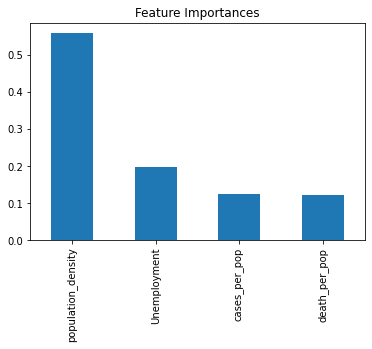

In [25]:
df = pd.merge(county, area)
df['population_density'] = df['TotalPop']/df['area']

trump = df['percentage20_Donald_Trump']

covid_data = df.drop(['area','FamilyWork', 'SelfEmployed', 'PublicWork', 'PrivateWork', 'Employed', 'MeanCommute', 'WorkAtHome', 'OtherTransp', 'Walk', 'Transit', 
                      'Carpool', 'Drive', 'Production', 'Construction', 'Office', 'Service', 'Professional', 'ChildPoverty', 'Poverty', 'IncomePerCapErr', 
                      'IncomePerCap', 'IncomeErr', 'Income', 'VotingAgeCitizen', 'Pacific', 'Asian', 'Native', 'Black', 'White', 'Hispanic', 'Women', 'Men', 
                      'lat', 'long', 'percentage20_Donald_Trump', 'percentage20_Joe_Biden', 'votes20_Donald_Trump', 'votes20_Joe_Biden', 'percentage16_Donald_Trump', 
                      'percentage16_Hillary_Clinton', 'total_votes16', 'votes16_Donald_Trump', 'votes16_Hillary_Clinton', 'county', 'state'],  axis=1)

covid_data["cases_per_pop"] = covid_data['cases'] / covid_data['TotalPop'] 
covid_data['death_per_pop'] = covid_data['deaths'] / covid_data['TotalPop']
covid_data = covid_data.drop(['TotalPop', 'total_votes20', 'cases', 'deaths'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(covid_data, trump, test_size=0.33)

gb = XGBRegressor(random_state=42, n=250, learning_rate=.1)

gb.fit(x_train, y_train)

import matplotlib.pylab as plt
preds = gb.predict(x_test)
print(mean_absolute_error(y_test,preds))

# get importance
importance = gb.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d %s, Score: %.5f' % (i,covid_data.columns[i] ,v))
# plot feature importance
feat_imp = pd.Series(gb.feature_importances_, covid_data.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

In [260]:
df = pd.merge(county, area)
df['population_density'] = df['TotalPop']/df['area']

trump = df['percentage20_Donald_Trump']

df = df.drop([ 'percentage20_Donald_Trump', 'percentage20_Joe_Biden', 'votes20_Donald_Trump', 'votes20_Joe_Biden', 'percentage16_Donald_Trump', 
                      'percentage16_Hillary_Clinton', 'total_votes16', 'votes16_Donald_Trump', 'votes16_Hillary_Clinton','county', 'state'],  axis=1)

df["cases_per_pop"] = df['cases'] / df['TotalPop'] 
df['death_per_pop'] = df['deaths'] / df['TotalPop']
df = df.drop(['TotalPop', 'total_votes20', 'cases', 'deaths'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(df, trump, test_size=0.33)

gb = XGBClassifier(random_state=42)

gb.fit(train_features, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

0.03752730883813307
Feature: 0 lat, Score: 0.02374
Feature: 1 long, Score: 0.02198
Feature: 2 Men, Score: 0.02373
Feature: 3 Women, Score: 0.02096
Feature: 4 Hispanic, Score: 0.02472
Feature: 5 White, Score: 0.02845
Feature: 6 Black, Score: 0.02868
Feature: 7 Native, Score: 0.02531
Feature: 8 Asian, Score: 0.03004
Feature: 9 Pacific, Score: 0.02263
Feature: 10 VotingAgeCitizen, Score: 0.02249
Feature: 11 Income, Score: 0.02344
Feature: 12 IncomeErr, Score: 0.02547
Feature: 13 IncomePerCap, Score: 0.02432
Feature: 14 IncomePerCapErr, Score: 0.02521
Feature: 15 Poverty, Score: 0.02558
Feature: 16 ChildPoverty, Score: 0.02630
Feature: 17 Professional, Score: 0.02920
Feature: 18 Service, Score: 0.02767
Feature: 19 Office, Score: 0.02473
Feature: 20 Construction, Score: 0.02954
Feature: 21 Production, Score: 0.02721
Feature: 22 Drive, Score: 0.02633
Feature: 23 Carpool, Score: 0.02654
Feature: 24 Transit, Score: 0.02855
Feature: 25 Walk, Score: 0.02563
Feature: 26 OtherTransp, Score: 0.0249

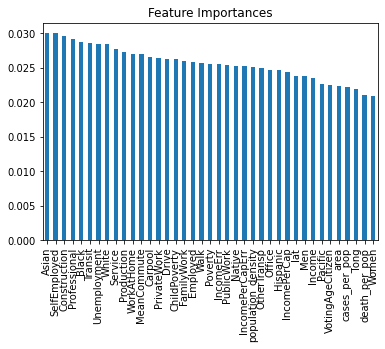

In [261]:
from sklearn.metrics import mean_absolute_error

preds = gb.predict(x_test)
print(mean_absolute_error(y_test,preds))

import matplotlib.pylab as plt

# get importance
importance = gb.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d %s, Score: %.5f' % (i,df.columns[i] ,v))
# plot feature importance
feat_imp = pd.Series(gb.feature_importances_, df.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

In [262]:
print(feat_imp)

Asian                 0.030036
SelfEmployed          0.029971
Construction          0.029545
Professional          0.029200
Black                 0.028678
Transit               0.028552
Unemployment          0.028458
White                 0.028454
Service               0.027669
Production            0.027210
WorkAtHome            0.027005
MeanCommute           0.026929
Carpool               0.026541
PrivateWork           0.026421
Drive                 0.026332
ChildPoverty          0.026295
FamilyWork            0.025976
Employed              0.025794
Walk                  0.025629
Poverty               0.025585
IncomeErr             0.025471
PublicWork            0.025428
Native                0.025310
IncomePerCapErr       0.025206
population_density    0.025161
OtherTransp           0.024925
Office                0.024735
Hispanic              0.024716
IncomePerCap          0.024318
lat                   0.023741
Men                   0.023726
Income                0.023439
Pacific 